In [55]:
#IMPORT DELLE LIBRERIE
import numpy as np 
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

import skimage.transform as trans
from skimage import io, color
from skimage.util import random_noise

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [56]:
#DOWNLOAD DEL DATASET
lfw_dataset=fetch_lfw_people(resize=0.256,download_if_missing=True,slice_=None,color=True)
print(lfw_dataset.images.shape)
X=lfw_dataset.images
y=lfw_dataset.target


#SPLIT DEL DATASET PER IL TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2)

#SPLIT DEL DATASET PER IL VALIDATION SET
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.1)

(13233, 64, 64, 3)


In [57]:
#DIMENSIONI DEL TRAINING SET
X_train.shape

(9527, 64, 64, 3)

In [58]:
#DIMENSIONI DEL TEST SET
X_test.shape

(2647, 64, 64, 3)

In [59]:
#DIMENSIONI DEL VALIDATION SET
X_val.shape

(1059, 64, 64, 3)

In [60]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI
noise_factor = 0.2

X_train_noisy = random_noise(X_train, mode="s&p",clip=True, amount=noise_factor)
X_test_noisy = random_noise(X_test, mode="s&p",clip=True, amount=noise_factor)
X_val_noisy = random_noise(X_val, mode="s&p",clip=True, amount=noise_factor)

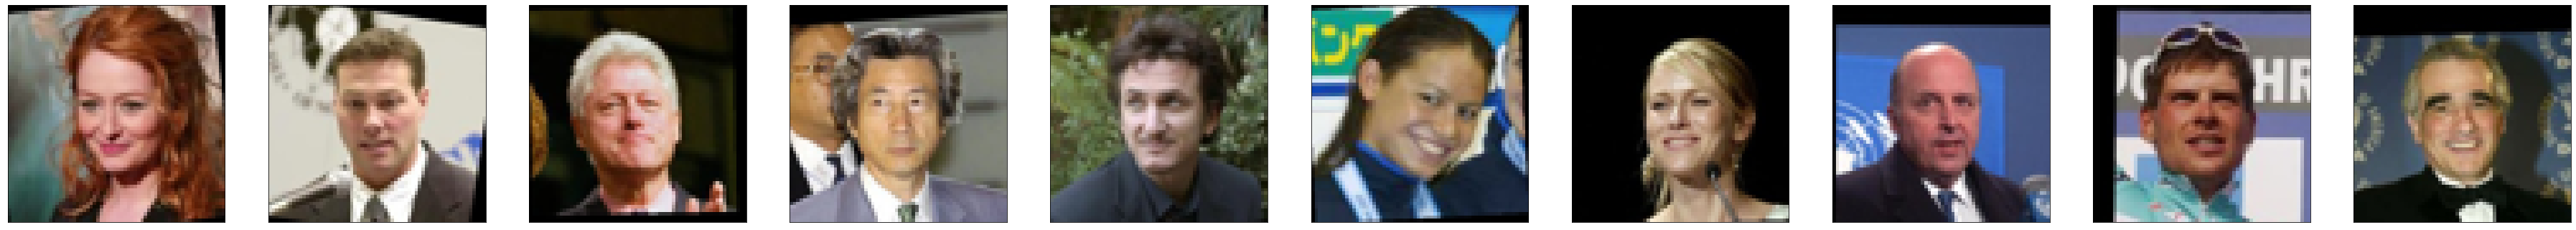

In [61]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

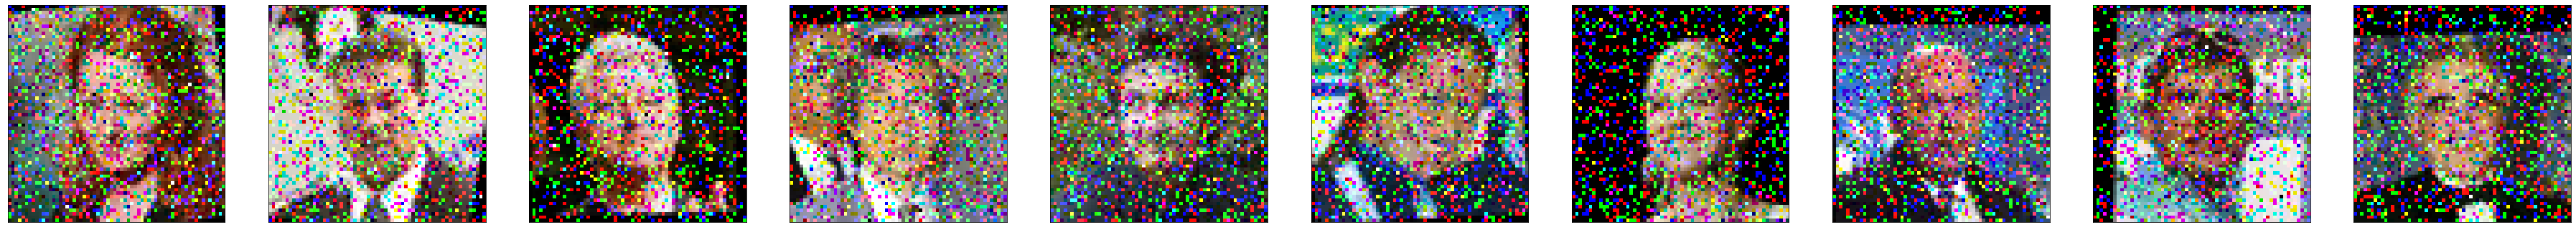

In [62]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET COL RUMORE
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [63]:
import numpy as np
from keras.models import *
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract


inpt = Input(shape=(None,None,3))
# 1st layer, Conv+relu
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
x = Activation('relu')(x)
# 15 layers, Conv+BN+relu
for i in range(15):
  x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
  x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
  x = Activation('relu')(x)   
# last layer, Conv
x = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(x)
x = Subtract()([inpt, x])   # input - noise
model = Model(inputs=inpt, outputs=x)
model.compile(optimizer=Adam(), loss=['mse'])
    

In [64]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_85 (Conv2D)             (None, None, None,   1792        ['input_6[0][0]']                
                                64)                                                               
                                                                                                  
 activation_80 (Activation)     (None, None, None,   0           ['conv2d_85[0][0]']              
                                64)                                                         

In [65]:
#TRAINING DEL MODELLO
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)
history = model.fit(X_train_noisy, X_train, epochs=100, batch_size=16, validation_data=(X_val_noisy,X_val), callbacks=[callback])

Epoch 1/100
596/596 [==============================] - 45s 74ms/step - loss: 0.0423 - val_loss: 0.0237
Epoch 2/100
596/596 [==============================] - 44s 73ms/step - loss: 0.0074 - val_loss: 0.0139
Epoch 3/100
596/596 [==============================] - 44s 74ms/step - loss: 0.0039 - val_loss: 0.0110
Epoch 4/100
596/596 [==============================] - 44s 73ms/step - loss: 0.0026 - val_loss: 0.0056
Epoch 5/100
596/596 [==============================] - 45s 75ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 6/100
596/596 [==============================] - 45s 76ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/100
596/596 [==============================] - 44s 74ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 8/100
596/596 [==============================] - 44s 73ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 9/100
596/596 [==============================] - 45s 75ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 10/100
596/596 [==============================] - 45s 76ms/step - l

In [66]:
#TEST DEL MODELLO SUL TEST SET
predict = model.predict(X_test_noisy)

83/83 [==============================] - 4s 40ms/step


In [67]:
predict.shape

(2647, 64, 64, 3)

In [68]:
n=10

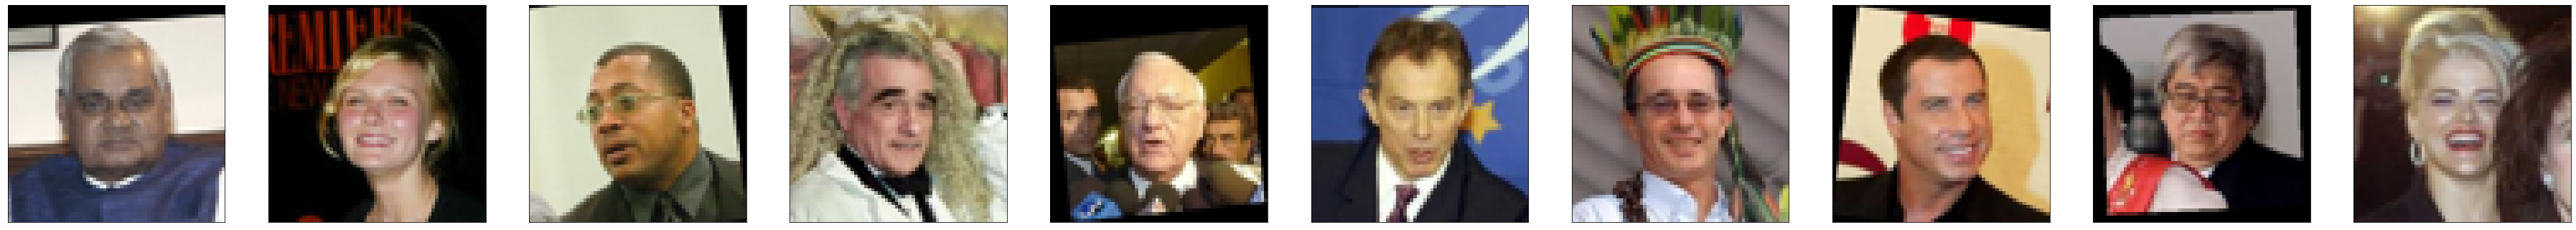

In [69]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

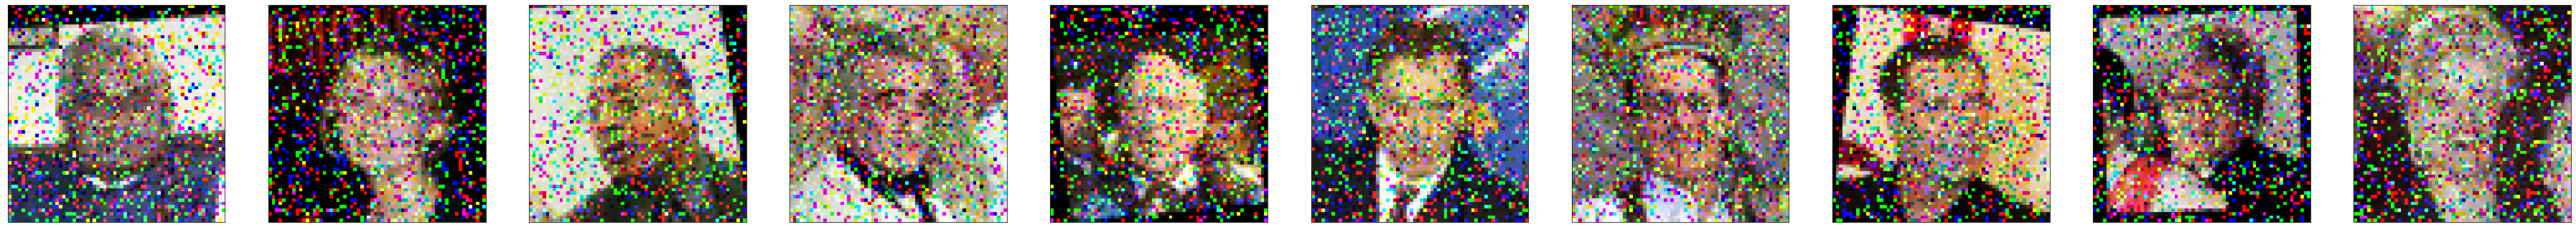

In [70]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET COL RUMORE
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

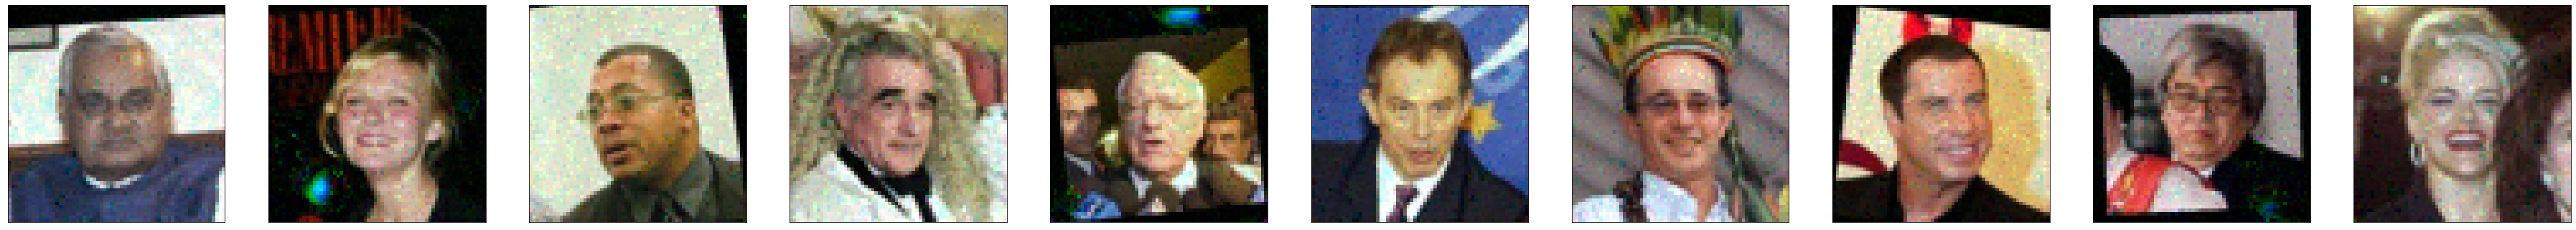

In [71]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET SENZA RUMORE (OUTPUT DELLA UNET)
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [72]:
NUMBER_OF_TEST_IMAGES = len(X_test)

mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.0024269957
Mean Absolute Error: 0.026016666
Root Mean Squared Error: 0.049264546


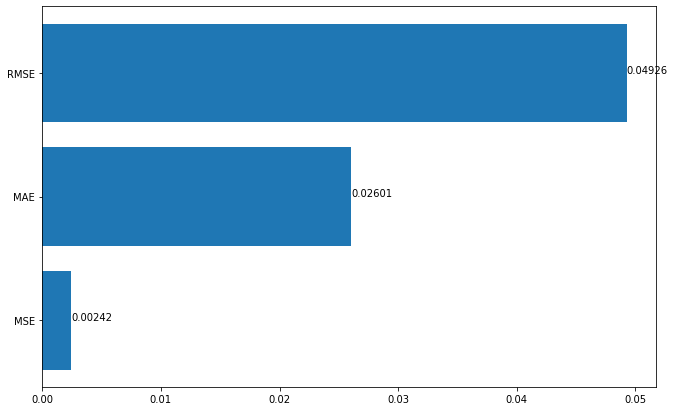

In [73]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()